# Steel Plant Complaints - Data Analysis - Part2

In this part, models will be created to forecast the following
- number of complaints (overall) in next few days/weeks/month
- number of complaints (per category - for top 4 categories) in next few days/weeks/month
- number of complaints (per sector - for top 3 sectors) in next few days/weeks/month
- spare parts forcasting  

For the above forcasting **ARIMA (Autoregressive Integrated Moving Average)** would be implemented

In [48]:
#import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [49]:
# loading dataset
df = pd.read_csv("trainee_complaint.csv") 

### Parse df (Dataframe) as time series data 

In [50]:
def func(date_time):
    #split date and time
    date,time=date_time.split()    
    return {'DATE':date, 'TIME':time}


In [51]:
extracted_df = pd.concat([df, df.COMPLAINT_DATE.apply(lambda date_time: pd.Series(func(date_time)))], axis=1)

In [52]:
extracted_df.index = pd.to_datetime(extracted_df.DATE)
extracted_df.head()

,SLNO,COMPLAINT_DATE,QTR_NO,SECTOR,CAT_DESCRIPTION,COMPLAINT_TYPE,COMPLAINT_ITEM,COMPLAINT_PROBLEM,COMPLAINT_LOCATION,STATUS,REMARKS,RES_PREF_TIME,SUBLOCATION,DATE,TIME
DATE,,,,,,,,,,,,,,,
2021-06-02,1,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Hall,NEW,NaN,NaN,NaN,6/2/21,9:12
2021-06-02,2,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Dining,NEW,NaN,NaN,NaN,6/2/21,9:12
2021-06-02,3,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 2,NEW,NaN,NaN,NaN,6/2/21,9:12
2021-06-02,4,6/2/21 9:12,201R,SS,ELECTRICAL,Fan / Regulator / Exhaust fan,Fan,NaN,Bed Room - 1,NEW,NaN,NaN,NaN,6/2/21,9:12
2021-06-02,5,6/2/21 9:12,201R,SS,ELECTRICAL,Calling Bell / Bell push switch,NaN,NaN,NaN,NEW,NaN,NaN,NaN,6/2/21,9:12


#### Number of complaints (overall)

In [53]:
complaints_per_day=extracted_df.groupby(extracted_df.index).count()["SLNO"]
print(type(complaints_per_day))
complaints_per_day.head()

<class 'pandas.core.series.Series'>


DATE
2021-02-17     82
2021-02-18    221
2021-02-19    368
2021-02-20    379
2021-02-21    219
Name: SLNO, dtype: int64

In [54]:
complaints_per_day.tail()

DATE
2021-05-29    280
2021-05-30    173
2021-05-31    420
2021-06-01    292
2021-06-02     65
Name: SLNO, dtype: int64

In [55]:
complaints_per_day.size

106

In [56]:
complaints_per_day.describe()

count    106.000000
mean     324.518868
std      114.821703
min       65.000000
25%      225.500000
50%      315.500000
75%      409.500000
max      580.000000
Name: SLNO, dtype: float64

- The given data ranges from 17-02-2021 to 02-06-2021 covering 106 days.
- Average number of complaints per day is 324, with maximum being 580 and minimum being 65.

<AxesSubplot:xlabel='DATE'>

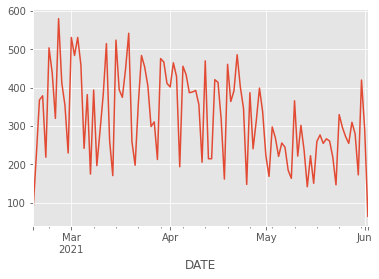

In [57]:
complaints_per_day.plot()

In [58]:
#using rolling window to smooth out the graphs
complaints_per_day_mean = complaints_per_day[:-1].rolling(window = 10).mean()[10:]

<AxesSubplot:xlabel='DATE'>

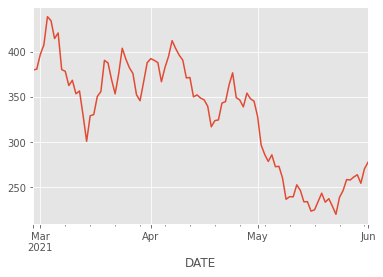

In [59]:
complaints_per_day_mean.plot()

From the above graph we can see that more number of complaints were during March, and complaints during May were less 

**ARIMA**  

Parameters for ARIMA are:
- p : which is given by plot_acf
- d : difference (usually between 0-2)
- q : which is given by plot_pacf

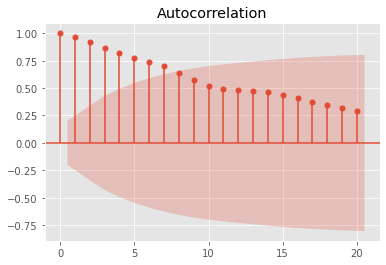

In [60]:
plot_acf(complaints_per_day_mean);

From the above graph p value for 8 is below critical limit. Hence we can consider p=8.

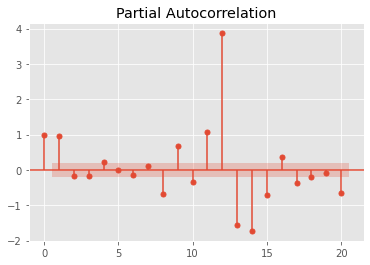

In [61]:
plot_pacf(complaints_per_day_mean);

From the above graph q value for 2 is below critical limit. Hence we can consider q=2.

In [62]:
#splitting into train and test
train=complaints_per_day_mean[0:80]
test=complaints_per_day_mean[80:]
print("Train size:", train.size)
print("Test size:", test.size)

Train size: 80
Test size: 15


In [63]:
#p=8, d=1, q=2
complaints_model=ARIMA(train, order=(8,1,2))

In [64]:
complaints_model_fit=complaints_model.fit()

In [65]:
#lesser the aic score, better is the model
complaints_model_fit.aic

634.2603642836082

In [66]:
complaints_forecast = complaints_model_fit.forecast(steps = test.size)[0]


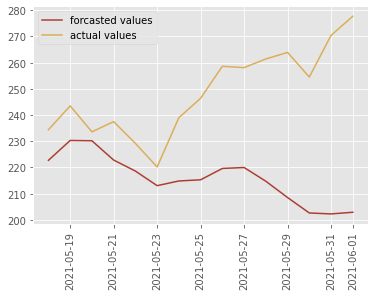

In [67]:
plt.xticks(rotation=90)
plt.plot(test.index, complaints_forecast, color='#ac3e31')
plt.plot(test.index, test.values, color='#dbae58')
plt.legend(['forcasted values','actual values'])
#plt.show()

In the above graph, forecasted valued predicted are low compared to actual values. This is an expected result, as their was drop in number of complaints during May, but from mid May the complaints started rising again.

**Using the complete dataset to forecast number of complaints in next month**

In [68]:
complaints_model2=ARIMA(complaints_per_day_mean, order=(8,0,2))

In [69]:
complaints_model_fit2=complaints_model2.fit()

In [70]:
complaints_forecast = complaints_model_fit2.forecast(steps = 30)[0]

In [71]:
print("Number of complaints to be expected next month:",sum(complaints_forecast))

Number of complaints to be expected next month: 9594.513386979199


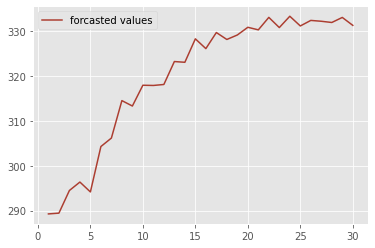

In [72]:

plt.plot(range(1,31), complaints_forecast, color='#ac3e31')
plt.legend(['forcasted values'])
#plt.show()

From the above graph the number of complaints per day would increase from 290 to 330 gradually on an average.

In [73]:
#summarizing above analysis

In [74]:
def analyze(extracted_df, col,feature):
    feature_df = extracted_df[extracted_df[col]==feature]
    complaints_per_day_feature=feature_df.groupby(feature_df.index).count()["SLNO"]
    complaints_per_day_feature.plot()
    #using rolling window to smooth out the graphs
    complaints_per_day_mean_feature = complaints_per_day_feature[:-1].rolling(window = 10).mean()[10:]
    complaints_per_day_mean_feature.plot()
    plt.legend(['actual values','smoothed values'])
    return complaints_per_day_mean_feature

In [75]:
#plot_acf(complaints_per_day_mean);

In [76]:
#plot_pacf(complaints_per_day_mean);

In [77]:
def ARIMA_testing(complaints_per_day_mean_feature, p,d,q):
    #splitting into train and test
    train=complaints_per_day_mean_feature[0:80]
    test=complaints_per_day_mean_feature[80:]
    print("Train size:", train.size)
    print("Test size:", test.size)
    complaints_model=ARIMA(train, order=(8,1,2))
    complaints_model_fit=complaints_model.fit()
    #lesser the aic score, better is the model
    print("AIC score:",complaints_model_fit.aic)
    complaints_forecast = complaints_model_fit.forecast(steps = test.size)[0]
    plt.xticks(rotation=90)
    plt.plot(test.index, complaints_forecast, color='#ac3e31')
    plt.plot(test.index, test.values, color='#dbae58')
    plt.legend(['forcasted values','actual values'])
    #plt.show()

In [78]:
def ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q):
    complaints_model2=ARIMA(complaints_per_day_mean_feature, order=(8,0,2))
    complaints_model_fit2=complaints_model2.fit()
    complaints_forecast = complaints_model_fit2.forecast(steps = 30)[0]
    print("Number of complaints to be expected next month:",round(sum(complaints_forecast)))
    plt.plot(range(1,31), complaints_forecast, color='#ac3e31')
    plt.legend(['forcasted values'])
    

### Analysis Category wise

*The above analysis would be repeated for top 4 categories (i.e) ELECTRICAL, WATER SUPPLY, CIVIL, and PUBLIC HEALTH as these are the categories where number of complaints are more.*

A. ELECTRICAL

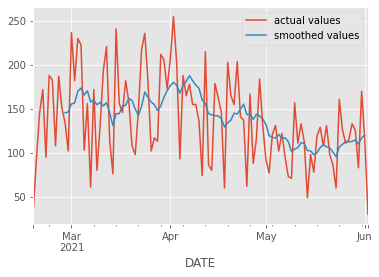

In [79]:
complaints_per_day_mean_feature=analyze(extracted_df,"CAT_DESCRIPTION", "ELECTRICAL")

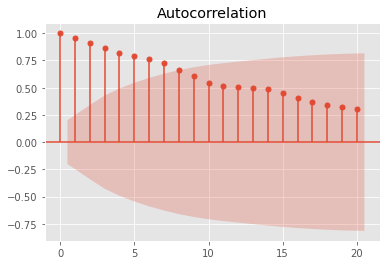

In [80]:
plot_acf(complaints_per_day_mean_feature);

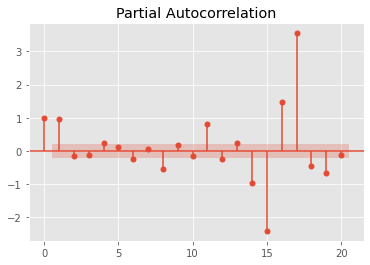

In [81]:
plot_pacf(complaints_per_day_mean_feature);

In [82]:
p,d,q=8,0,2

Train size: 80
Test size: 15
AIC score: 529.3453033309088


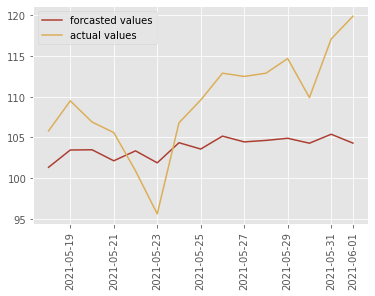

In [83]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 4037.0


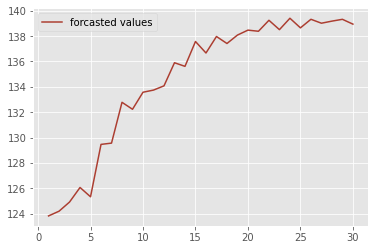

In [84]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

B. WATER SUPPLY

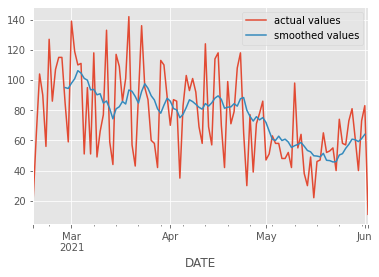

In [85]:
complaints_per_day_mean_feature=analyze(extracted_df,"CAT_DESCRIPTION", "WATER SUPPLY")

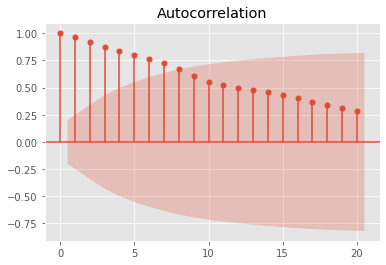

In [86]:
plot_acf(complaints_per_day_mean_feature);

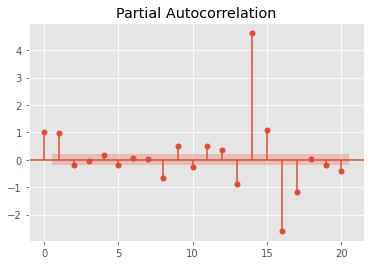

In [87]:
plot_pacf(complaints_per_day_mean_feature);

Train size: 80
Test size: 15
AIC score: 411.8817034003804


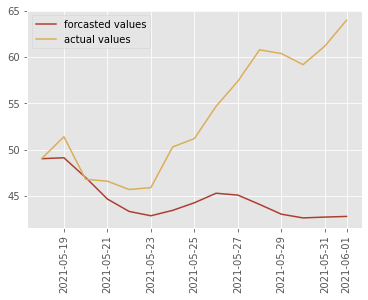

In [88]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 2313.0


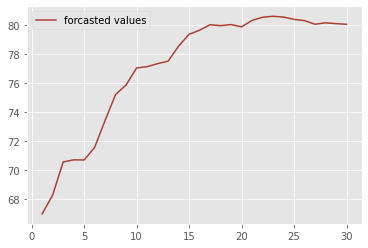

In [89]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

C. CIVIL

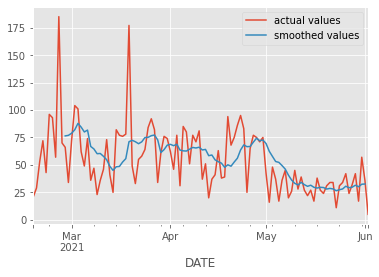

In [90]:
complaints_per_day_mean_feature=analyze(extracted_df, "CAT_DESCRIPTION","CIVIL")

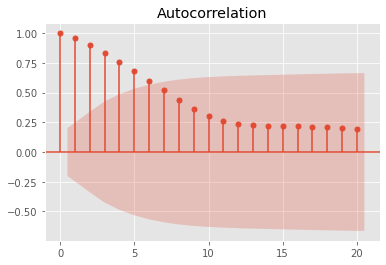

In [91]:
plot_acf(complaints_per_day_mean_feature);

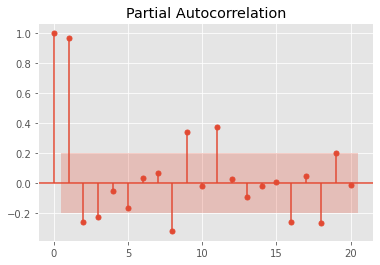

In [92]:
plot_pacf(complaints_per_day_mean_feature);

In [93]:
p,d,q=6,0,3

Train size: 80
Test size: 15
AIC score: 437.1076262305196


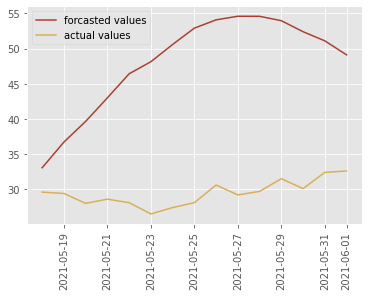

In [94]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 1486.0


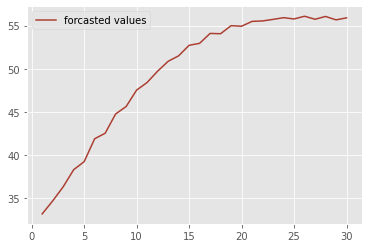

In [95]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

D. PUBLIC HEALTH

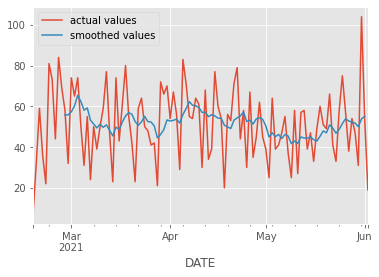

In [96]:
complaints_per_day_mean_feature=analyze(extracted_df, "CAT_DESCRIPTION","PUBLIC HEALTH")

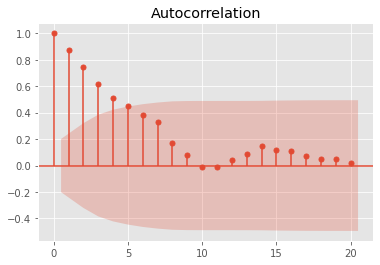

In [97]:
plot_acf(complaints_per_day_mean_feature);

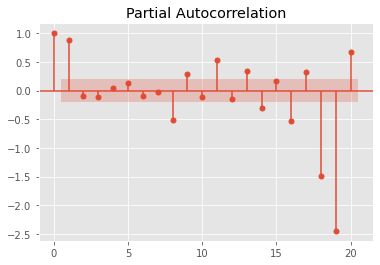

In [98]:
plot_pacf(complaints_per_day_mean_feature);

In [99]:
p,d,q=5,0,2

Train size: 80
Test size: 15
AIC score: 355.1500628971434


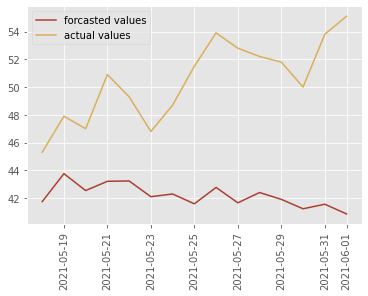

In [100]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 1558.0


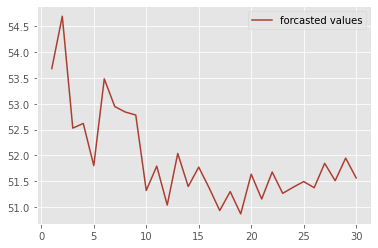

In [101]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

**Summary**

|Category               | Number of complaints forecasted in next month |
|-----------------------|---------------------------------------:|
|Electrical             |                                    4037|
|Water Supply           |                                    2313|
|Civil                  |                                    1485|
|Public Health          |                                    1558|


### Analysis Sector wise - For top 3 sectors

A. Sector A

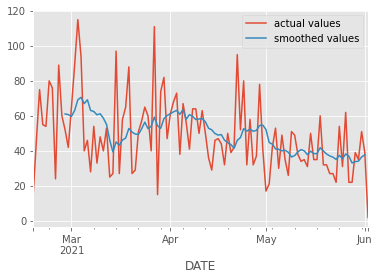

In [102]:
complaints_per_day_mean_feature=analyze(extracted_df, "SECTOR","A")

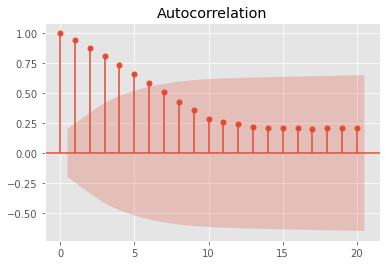

In [103]:
plot_acf(complaints_per_day_mean_feature);

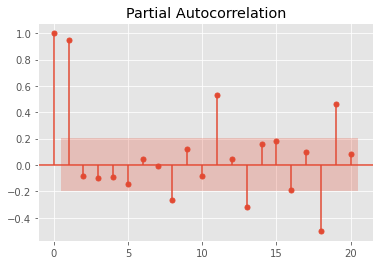

In [104]:
plot_pacf(complaints_per_day_mean_feature);

In [105]:
p,d,q=6,0,2

Train size: 80
Test size: 15
AIC score: 406.56488282464693


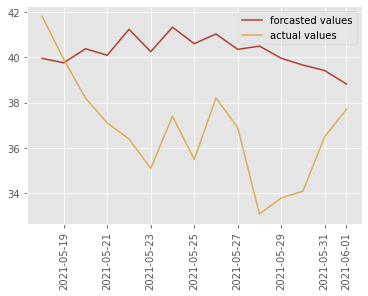

In [106]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 1421.0


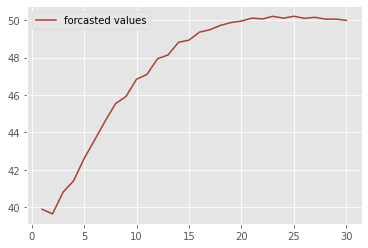

In [107]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

B. Sector C

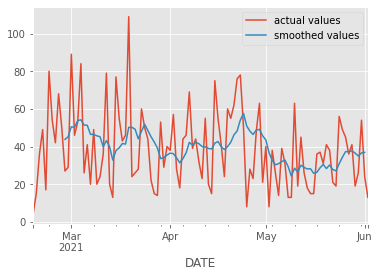

In [108]:
complaints_per_day_mean_feature=analyze(extracted_df, "SECTOR","C")

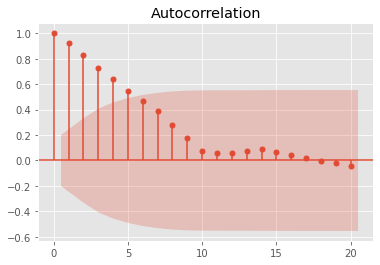

In [109]:
plot_acf(complaints_per_day_mean_feature);

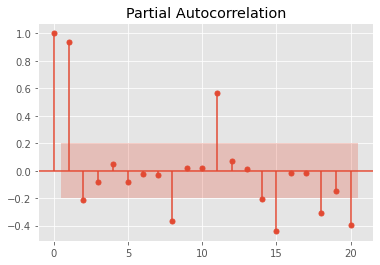

In [110]:
plot_pacf(complaints_per_day_mean_feature);

In [111]:
p,d,q=6,0,2

Train size: 80
Test size: 15
AIC score: 418.3176959379156


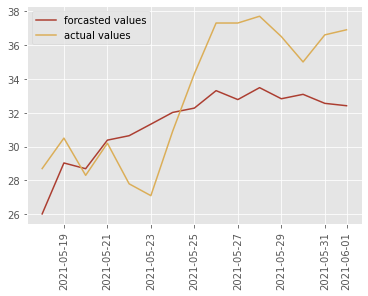

In [112]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 1182.0


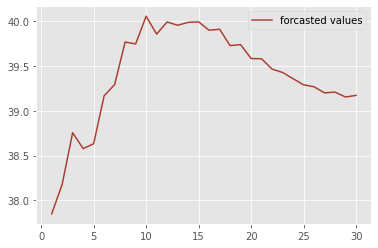

In [113]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

C. Sector F

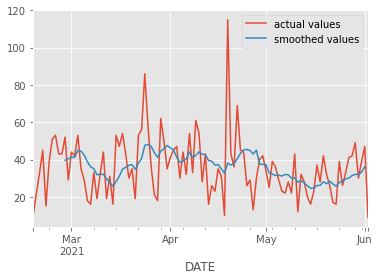

In [114]:
complaints_per_day_mean_feature=analyze(extracted_df, "SECTOR","F")

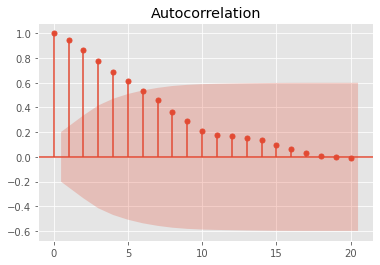

In [115]:
plot_acf(complaints_per_day_mean_feature);

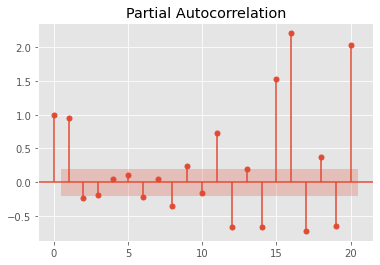

In [116]:
plot_pacf(complaints_per_day_mean_feature);

In [117]:
p,d,q=6,0,2

Train size: 80
Test size: 15
AIC score: 359.24261323249254


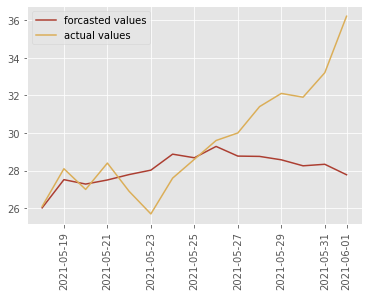

In [118]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 1128.0


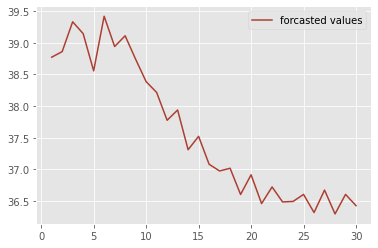

In [119]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

**Summary**

|Sector       | Number of complaints forecasted in next month |
|-------------|---------------------------------------:|
|A            |                                     1421|
|C            |                                     1181|
|F            |                                     1127|


### Analysis Status wise - For Completed or New or Closed

A. NEW

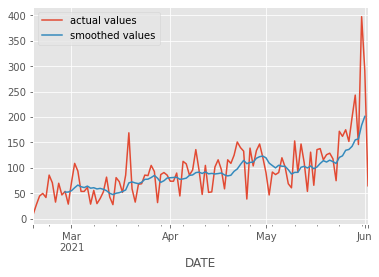

In [120]:
complaints_per_day_mean_feature=analyze(extracted_df, "STATUS","NEW")

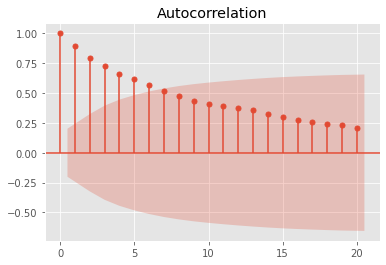

In [121]:
plot_acf(complaints_per_day_mean_feature);

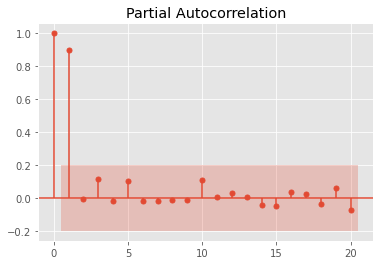

In [122]:
plot_pacf(complaints_per_day_mean_feature);

In [123]:
p,d,q=7,0,2

Train size: 80
Test size: 15
AIC score: 441.8282595273604


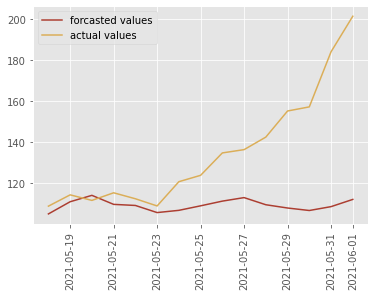

In [124]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

B. COMPLETED

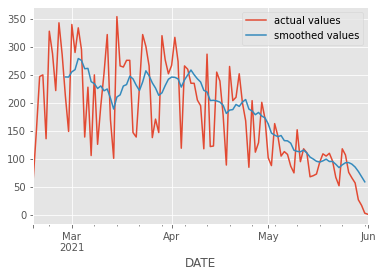

In [125]:
complaints_per_day_mean_feature=analyze(extracted_df, "STATUS","COMPLETED")

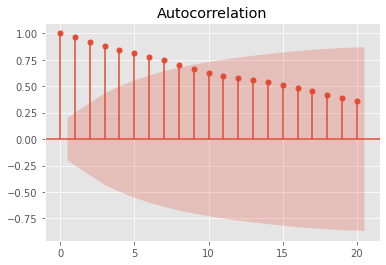

In [126]:
plot_acf(complaints_per_day_mean_feature);

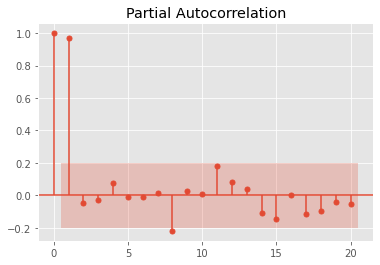

In [127]:
plot_pacf(complaints_per_day_mean_feature);

In [128]:
p,d,q=2,1,2

Train size: 80
Test size: 14
AIC score: 579.5794045635254


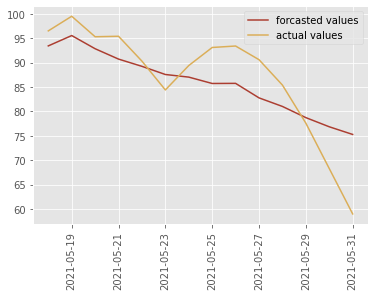

In [129]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

C. CLOSED

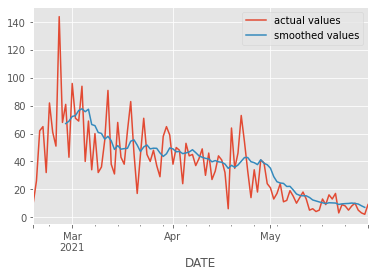

In [130]:
complaints_per_day_mean_feature=analyze(extracted_df, "STATUS","CLOSED")

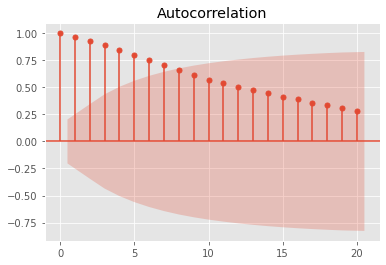

In [131]:
plot_acf(complaints_per_day_mean_feature);

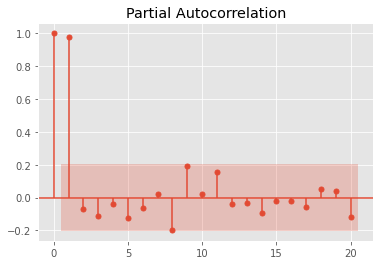

In [132]:
plot_pacf(complaints_per_day_mean_feature);

In [133]:
p,d,q=8,0,2

Train size: 80
Test size: 13
AIC score: 375.749795999964


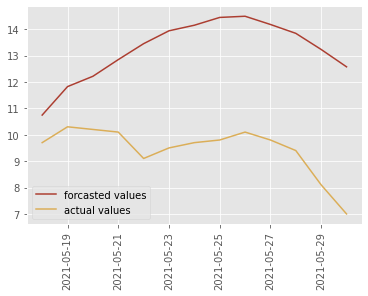

In [134]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

### Spare Parts Forcasting
Number of spare parts required in next month will be forcasted for top 5 spare parts.

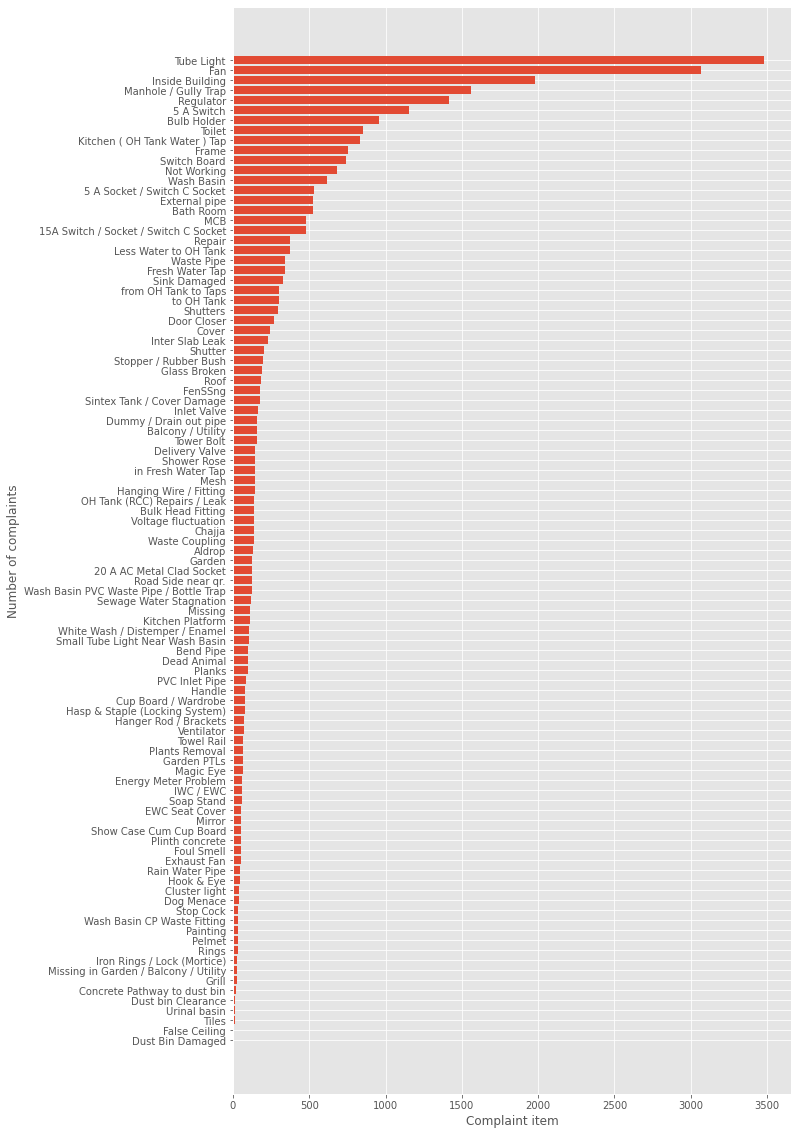

In [135]:
complaints_per_sector=extracted_df.groupby(by=["COMPLAINT_ITEM"]).count()
complaints_per_sector=complaints_per_sector.sort_values(by="SLNO")
plt.figure(figsize=(10,20))
plt.ylabel("Number of complaints")
plt.xlabel("Complaint item")
plt.barh(complaints_per_sector.index.values, complaints_per_sector['SLNO'] )
plt.show()

Based on above bar plot, top 5 spare parts are:
- Tube Light
- Fan 
- Regulator
- 5 A Switch
- Bulb Holder

A. Tube Light

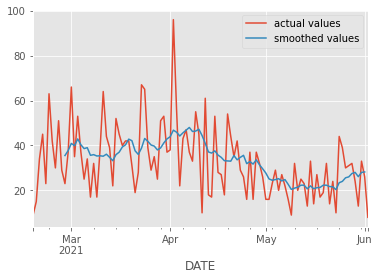

In [136]:
complaints_per_day_mean_feature=analyze(extracted_df, "COMPLAINT_ITEM","Tube Light")

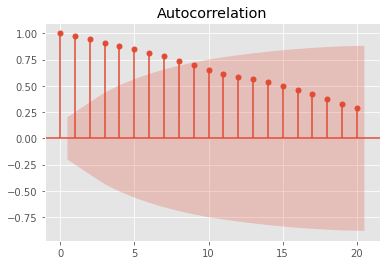

In [137]:
plot_acf(complaints_per_day_mean_feature);

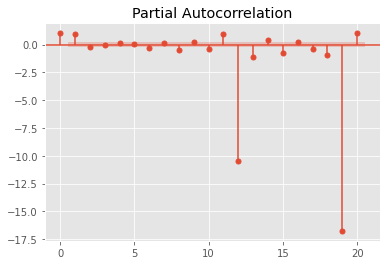

In [138]:
plot_pacf(complaints_per_day_mean_feature);

In [139]:
p,d,q=9,0,2

Train size: 80
Test size: 15
AIC score: 328.1317226606187


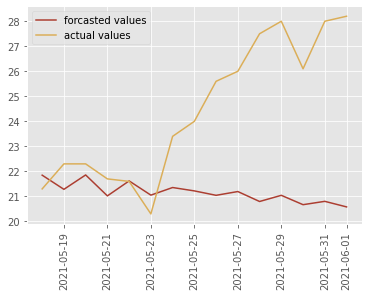

In [140]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 957.0


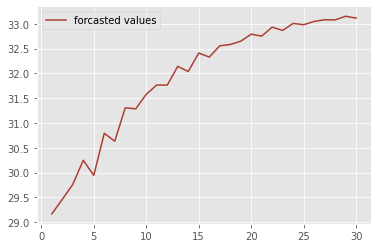

In [141]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

B. Fan

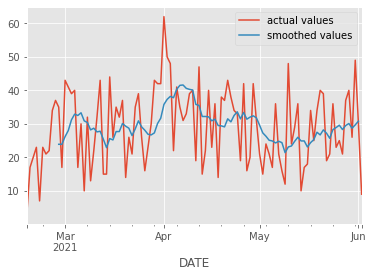

In [142]:
complaints_per_day_mean_feature=analyze(extracted_df, "COMPLAINT_ITEM","Fan")

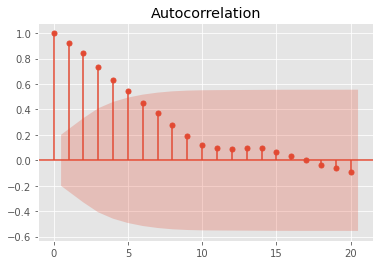

In [143]:
plot_acf(complaints_per_day_mean_feature);

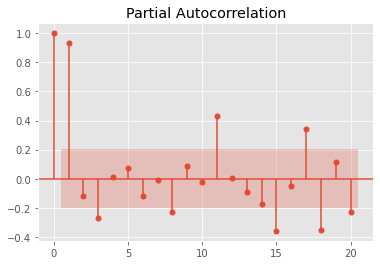

In [144]:
plot_pacf(complaints_per_day_mean_feature);

In [145]:
p,d,q=6,0,2

Train size: 80
Test size: 15
AIC score: 304.20141327655506


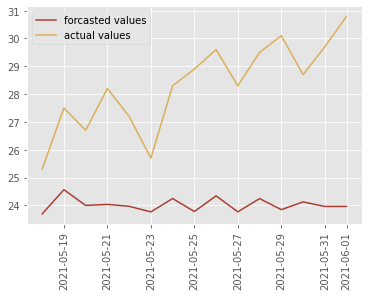

In [146]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 899.0


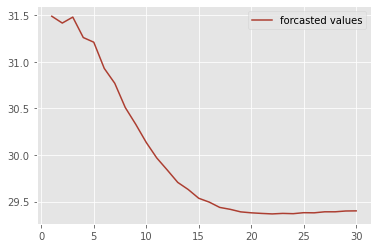

In [147]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

C. Regulator

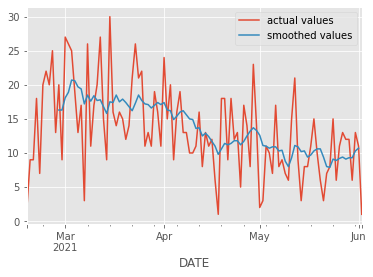

In [148]:
complaints_per_day_mean_feature=analyze(extracted_df, "COMPLAINT_ITEM","Regulator")

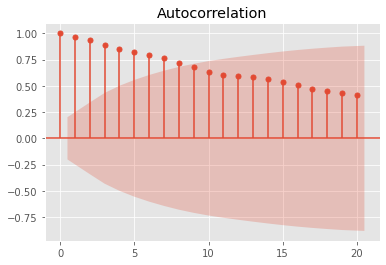

In [149]:
plot_acf(complaints_per_day_mean_feature);

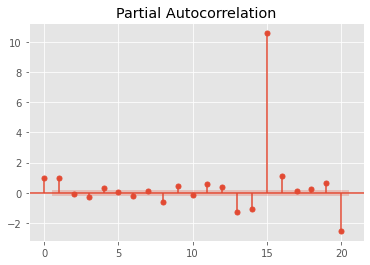

In [150]:
plot_pacf(complaints_per_day_mean_feature);

In [151]:
p,d,q=9,0,2

Train size: 80
Test size: 15
AIC score: 189.12978876257563


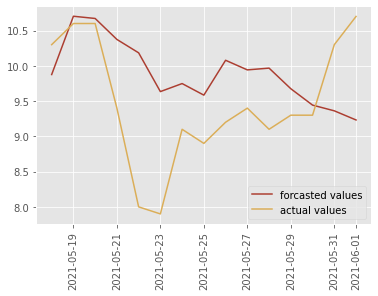

In [152]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 369.0


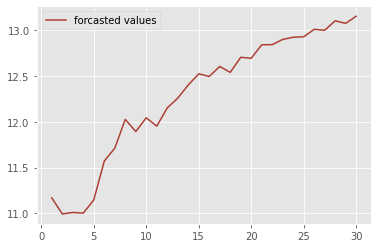

In [153]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

D. 5 A Switch

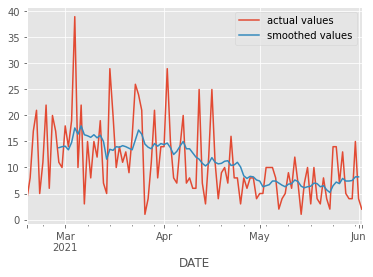

In [154]:
complaints_per_day_mean_feature=analyze(extracted_df, "COMPLAINT_ITEM","5 A Switch")

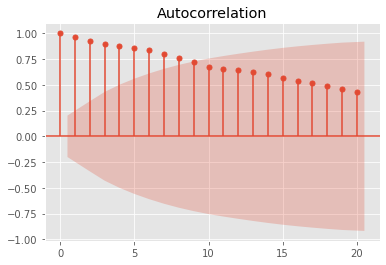

In [155]:
plot_acf(complaints_per_day_mean_feature);

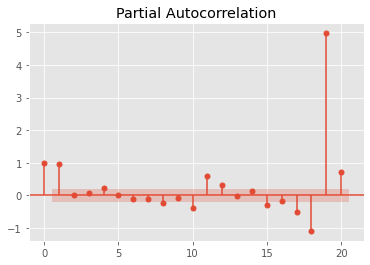

In [156]:
plot_pacf(complaints_per_day_mean_feature);

In [157]:
p,d,q=9,0,2

Train size: 80
Test size: 15
AIC score: 226.3693851184849


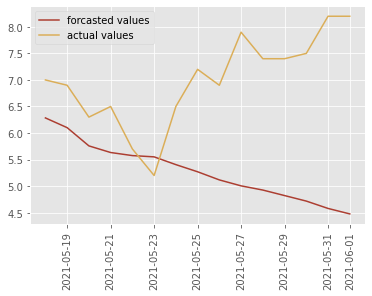

In [158]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 277.0


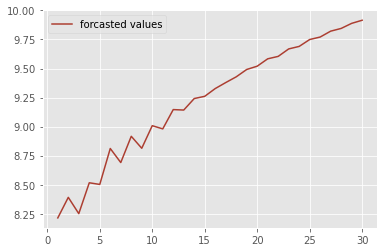

In [159]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

E. Bulb Holder

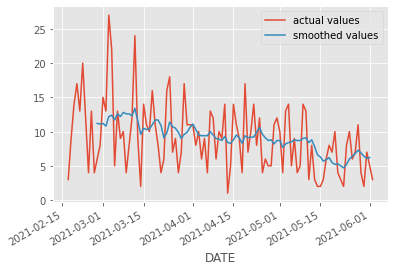

In [160]:
complaints_per_day_mean_feature=analyze(extracted_df, "COMPLAINT_ITEM","Bulb Holder")

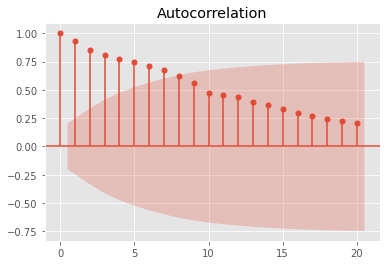

In [161]:
plot_acf(complaints_per_day_mean_feature);

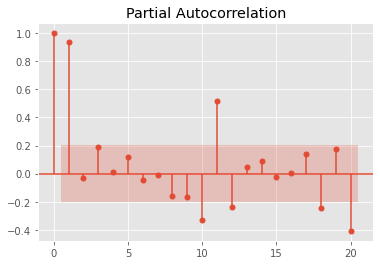

In [162]:
plot_pacf(complaints_per_day_mean_feature);

In [163]:
p,d,q=8,0,2

Train size: 80
Test size: 14
AIC score: 167.99426962007215


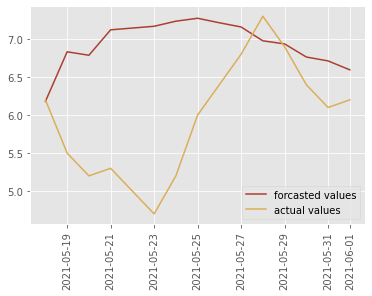

In [164]:
ARIMA_testing(complaints_per_day_mean_feature, p,d,q)

Number of complaints to be expected next month: 228.0


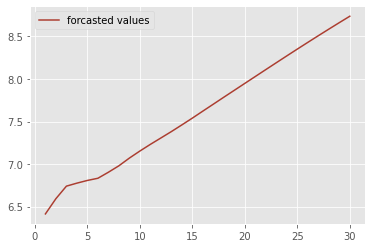

In [165]:
ARIMA_forecasting(complaints_per_day_mean_feature, p,d,q)

**Summary**


|Item                   | Number of items required in next month |
|-----------------------|---------------------------------------:|
|Tube Light             |                                     957|
|Fan                    |                                     899|
|Regulator              |                                     369|
|5 A Switch             |                                     277|
|Bulb Holder            |                                     228|